In [1]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mm
import networkx as nx

from sqlalchemy import create_engine

import matplotlib.pyplot as plt

user = os.environ.get('DB_USERNAME')
pwd = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOSTNAME')
port = os.environ.get('DB_PORT')

url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/geodemo"
engine = create_engine(url)

In [2]:
x=338250
y=392200

In [3]:
def pgselect(table, buffer=100, x=338250, y=392250):
    sql = f'''
    SELECT * FROM {table} 
    WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'''
    return gpd.read_postgis(sql, engine, geom_col='geometry')

In [4]:
roads = pgselect('openroads')

In [5]:
uprn = pgselect('openuprn')

In [6]:
bdgs = pgselect('openmaplocal')

In [7]:
rwys = pgselect('railways')

In [8]:
nodes = pgselect('roadnodes')

In [9]:
roads.roadFunction.unique()

array(['Secondary Access Road', 'Local Road'], dtype=object)

In [10]:
localroads = roads.loc[roads.roadFunction=='Local Road']

In [11]:
def closest_road(pt_row):
    rd_df= localroads
    # for each points row
    # get point id
    pt_it = pt_row.UPRN
    # get distance to all roads,
    dfdict = dict()
    for i in range(len(rd_df)):
        rd_row = rd_df.iloc[i]
        dfdict[i] = dict()
        dfdict[i]['rd_id'] = rd_row.id
        dfdict[i]['distance'] = pt_row.geometry.distance(rd_row.geometry)
    return pd.DataFrame(dfdict).T.sort_values('distance').iloc[0].values[0]

In [12]:
uprn[['nearest_rd']]=uprn.apply(closest_road,axis=1)

In [13]:
localroads['color'] = localroads.index

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [14]:
mapper = {d[1]:d[0] for d in dict(localroads.id.T).items()}

In [15]:
uprn['color'] = uprn.nearest_rd.apply(lambda x: mapper[x])

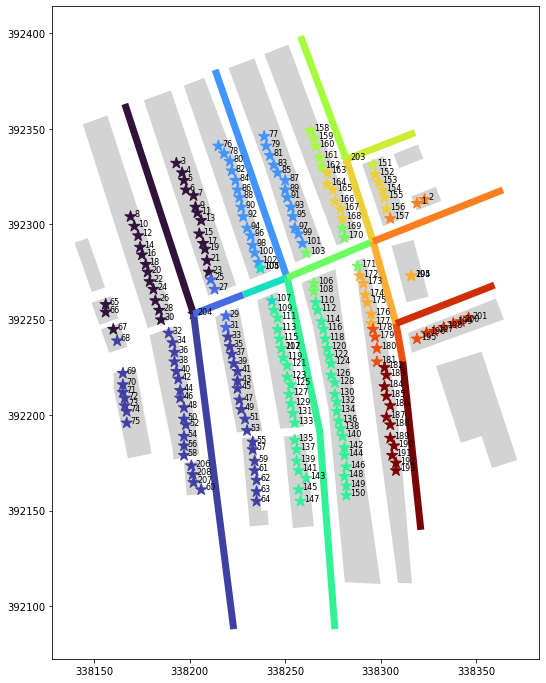

In [16]:
cmap = 'turbo'
fig, ax = plt.subplots(figsize=(12,12))
localroads.plot('color', ax=ax, cmap=cmap, linewidth=7)
# rwys.plot(ax=ax)
bdgs.plot(ax=ax, color='lightgray')
# nodes.plot(ax=ax, color='k')
uprn.plot('color',ax=ax, markersize=140, cmap=cmap, marker="*")
for i, point in enumerate(uprn.geometry):
    plt.text(point.x+2, point.y, str(i+1), color='k', fontsize=8)

In [17]:
df = pd.DataFrame(uprn.groupby('nearest_rd').describe().UPRN['count'])

In [18]:
df.sort_values('count')

,count
nearest_rd,
id932A7DAE-AB11-4797-A8B7-B8F49227723B,1.0
id18D3DE2B-A590-4310-BD30-9817660D4DFB,3.0
id8B6D546F-8749-4DDA-88B5-E02E80D1290A,3.0
idEC722FC0-5F27-4D70-9CA3-F5762A600315,4.0
idEF32B58C-0D94-4110-8D2D-3C884C938F70,5.0
idA355A472-115B-4649-8DCC-20F7D0B9888E,6.0
idE3471B95-8EC0-4159-844D-745F55479592,6.0
idFB63D4A6-32D1-4285-99DF-682A9C0351C0,6.0
idDE40FB3A-185E-4021-881D-D921F79F5D1F,8.0


In [19]:
localroads[['id','name1','length']].sort_values('length')

,id,name1,length
14,idEF32B58C-0D94-4110-8D2D-3C884C938F70,Snaefell Avenue,20
6,id8B6D546F-8749-4DDA-88B5-E02E80D1290A,Braddan Avenue,25
3,idEC722FC0-5F27-4D70-9CA3-F5762A600315,Braddan Avenue,28
10,id932A7DAE-AB11-4797-A8B7-B8F49227723B,Santon Avenue,39
11,idC6E80EE6-3740-42BA-A6C9-039B56172352,Snaefell Avenue,45
12,idDE40FB3A-185E-4021-881D-D921F79F5D1F,Snaefell Avenue,45
8,idA355A472-115B-4649-8DCC-20F7D0B9888E,Braddan Avenue,49
15,idFB63D4A6-32D1-4285-99DF-682A9C0351C0,Sulby Avenue,55
9,idE3471B95-8EC0-4159-844D-745F55479592,Snaefell Avenue,69
13,id18D3DE2B-A590-4310-BD30-9817660D4DFB,Braddan Avenue,73


<AxesSubplot:>

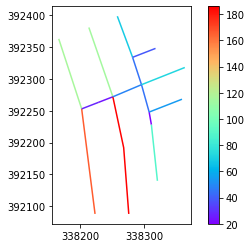

In [20]:
localroads.plot('length',cmap='rainbow',legend=True)